## 标定原理

单孔相机的成像模型基于透视投影原理，在实际应用中由于镜头和成像平面的误差，会给图像带来很多畸变。畸变主要分为径向畸变和切向畸变。



### 径向畸变

![](images/2023-08-23-10-19-30.png)

这种误差主要在相机的制造和安装时出现，下图为低价的单孔相机图像。可以看到当使用红色的线将棋盘的边界用直线标记后，边界并不和直线重合。

![](images/2023-08-23-09-39-18.png)

这种畸变可以使用下面的方程组进行纠正：

$$x_{corrected} = x(1+k_{1}r^{2}+k_{2}r^{4}+k_{3}r^{6})$$
$$y_{corrected} = y(1+k_{1}r^{2}+k_{2}r^{4}+k_{3}r^{6})$$


### 切向畸变
用于相机的镜头和成像单元不可能绝对平行。会造成图像中的某些点看上去的位置会比我们认为的位置要进一些。

![](images/2023-08-23-10-19-15.png)

可以通过下面的方程进行校正：

$$x_{corrected} = x + [2p_1xy + p_2(r^2+2x^2)]$$
$$y_{corrected} = y + [2p_1xy + p_2(r^2+2x^2)]$$



### 畸变系数
校正这两种畸变，我们只需要确定公式中的五个系数：

$$\text{Distortion cof ficients} = (k_1,k_2,p_1,p_2,k_3)$$


### 相机内参

下图形象的反应了相机成像的小孔成像的原理，其中小孔为焦点（Focal point），焦点到成像平面的距离（一般默认为虚拟成像平面分析）为焦距（Focal lenght）。

![](images/2023-08-23-09-35-47.png)

将模型使用几何分析：

![](images/2023-08-23-10-34-55.png)


可以得到相机坐标到像素坐标（模拟的成像平面）的变换关系：

$$\left\{\begin{matrix} 
  u = \frac {fy}z
  \\
  \\
  v = \frac {fy}z 
\end{matrix}\right. $$

在实际情况中并不是理想，实际中图像的坐标系往往在图片的左上角，两个坐标系存在一定的平移。

![](images/2023-08-23-11-11-18.png)

考虑主点偏移的情况：

$$\left\{\begin{matrix} 
  u = \frac {fy}z + O_x
  \\
  \\
  v = \frac {fy}z  + O_y
\end{matrix}\right. $$

使用齐次坐标方程表达为：

$$\begin{bmatrix}  
  u\\v\\1
\end{bmatrix}
= \frac{1}{Z} 
\begin{bmatrix}  
  f_x & 0 & O_x \\  
  0 & f_y & O_y \\  
  0 & 0 & 1  
\end{bmatrix} 
\begin{bmatrix}  
  X\\Y\\Z
\end{bmatrix} $$

这里的$f_x = \frac {f}{k}$，$f_y = \frac {f}{l}$为像素焦距，即单位长度的像素个数，单位为像素。
有了相机内参我们便可以知道像素点对应的归一化平面（距光心距离为1的平面）的 x y 坐标，注意不是真实的XY坐标，因为空间点的深度值在透视投影过程中丢失了。

在上面矩阵中中间的矩阵就是内参矩阵，其中焦距$(f_x,f_y)$，相机坐标系原点$(c_x,c_y)$这四个参数为内部参数。需要进行标定，它完全取决于相机自身，只需要计算一次。

$$\text{camera matrix} = \begin{bmatrix}  
  f_x & 0 & c_{x}\\  
  0 & f_y & c_y \\  
  0 & 0 & 1 
\end{bmatrix}$$

## OpenCV相机标定


根据公式可以知道，标定相机的内参矩阵，需要两组点，一个是像素平面的2D点，一个是真实世界的3D点。2D点也叫图像点,需要知道$(u,v)$的值，3D点也叫对象点，需要知道$(X,Y,Z)$的值。

图像点很容易获取，使用opencv的$cv.findChessboardCorners()$函数查找棋盘的角点。然后使用$cv.drawChessboardCorners()$绘制点，这些点会按顺序排列（从左到右，从上到下）。这里用的棋盘为7x6

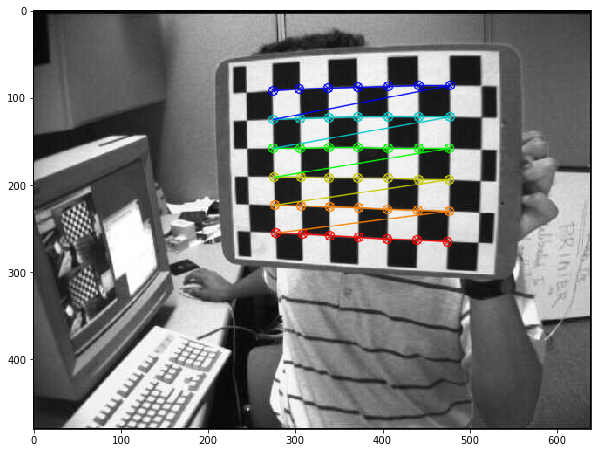

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

image = cv.imread("./chess_board_images/left01.jpg")

gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)

ret, corner = cv.findChessboardCorners(gray, (7,6))

cv.drawChessboardCorners(image, (7,6), corner, ret)

plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1])
plt.show()

$(X,Y,Z)$的值为真实世界的点，这里为了简单将$Z$的值设置为0（假设棋盘没有移动，而是相机在移动，并且第一个棋盘点在世界坐标系的原点位置），因此只需要传入(0,0),(1,0),(2,0)...，它们代表了点的位置。如果知道棋盘的单个方块大小，例如，为30mm，传入值就为(0,0),(30,0),(60,0)...，结果的单位为mm。

In [2]:
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

完整代码如下所示，这里采集了相机下面不同位置的棋盘图像，得到一组图像点用于计算。并使用$cv.cornerSubPix()$是采集到的点更加的准确，它会接受原始图像和角点位置，并在原始位置的一个小邻域内寻找最佳的角点位置。由于需要迭代，需要指定终止条件，如迭代次数或精度。

In [3]:
import numpy as np
import cv2 as cv
import glob
# 迭代终止条件
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# 设置目标点：(0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# 对象点和图像点列表
objpoints = [] # 真实世界空间的3d点
imgpoints = [] # 图像平面的2d点
images = glob.glob('./chess_board_images/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # 查找棋盘点
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # 如果找到棋盘点，加入对象点列表，图像列表
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # 绘制角点
        cv.drawChessboardCorners(img, (7,6), corners2, ret)
        cv.imshow('img', img)
        cv.waitKey(500)
cv.destroyAllWindows()

### 计算标定结果
得到了对象点和图像点后，使用$cv.calibrateCamera()$标定相机。它会返回相机的内参矩阵，畸变系数，旋转和变换向量等。


In [4]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, 
                                                  imgpoints, 
                                                  gray.shape[::-1], 
                                                  None, None)

print("camera matrix :\n",mtx)
print("distortion coefficients :\n",dist)

camera matrix :
 [[534.07088364   0.         341.53407554]
 [  0.         534.11914595 232.94565259]
 [  0.           0.           1.        ]]
distortion coefficients :
 [[-2.92971637e-01  1.07706962e-01  1.31038376e-03 -3.11018781e-05
   4.34798110e-02]]


### 畸变校正

现在我们得到了相机矩阵和畸变参数，直接畸变校正后图像是四周会出现黑色区域，如果畸变较大，如鱼眼镜头，四周黑色区域将会更大。opencv中使用$cv.getOptimalNewCameraMatrix()$得到自由缩放系数对相机矩阵进行优化。
如果缩放系数$alpha = 0$，返回的非畸变图像会带有少量的不想要的像素。也可以会在角点去除一些像素。如果$alpha = 1$，所有的像素都会被返回，还有一些黑色的区域。还会返回一个ROI图像，用来对结果进行裁剪。 

In [5]:
import cv2 as cv
img = cv.imread("./chess_board_images/left12.jpg")
h, w = img.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

使用$cv.undistort()$方法得到校正后的图像，并使用ROI对结果裁剪。

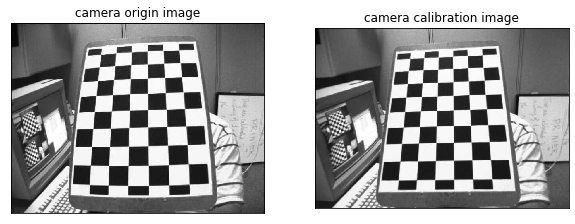

In [6]:
import matplotlib.pyplot as plt
dst = cv.undistort(img, mtx, dist, None, newcameramtx)

x,y,w,h = roi
dst = dst[y:y+h, x:x+w]


plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(img),plt.title("camera origin image")
plt.xticks([]),plt.yticks([])
plt.subplot(122),plt.imshow(dst),plt.title("camera calibration image")
plt.xticks([]),plt.yticks([])
plt.show()

最后的结果中可以看到所有的边界都变直了  